# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.  
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Задачи исследования

- Выполнить анализ данных  
Изучить поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?  
Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы.
- Проверить гипотезы:  
средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;  
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

## Описание данных

__Таблица users (информация о пользователях)__:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

__Таблица calls (информация о звонках)__:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

__Таблица messages (информация о сообщениях)__:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

__Таблица internet (информация об интернет-сессиях)__:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

__Таблица tariffs (информация о тарифах)__:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
# настраиваем окружение
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from math import ceil
import seaborn as sns
import numpy as np
from scipy import stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#users = pd.read_csv('C:\\Y.Practikum\\project_3\\dataset\\users.csv', sep=',')
users = pd.read_csv('/datasets/users.csv', sep=',')

users.info()
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [3]:
#calls = pd.read_csv('C:\\Y.Practikum\\project_3\\dataset\\calls.csv', sep=',')
calls = pd.read_csv('/datasets/calls.csv', sep=',')

calls.info()
calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
#internet = pd.read_csv('C:\\Y.Practikum\\project_3\\dataset\\internet.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',')

internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [5]:
#messages = pd.read_csv('C:\\Y.Practikum\\project_3\\dataset\\messages.csv', sep=',')
messages = pd.read_csv('/datasets/messages.csv', sep=',')

messages.info()
messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
#tariffs = pd.read_csv('C:\\Y.Practikum\\project_3\\dataset\\tariffs.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')

tariffs.info()
tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Вывод
- __таблица users__  
Выборка для 500 клиентов. Пропусков в данных нет. Почти все клиенты продолжают пользоваться услугами, 38 уже отключились
- __таблица calls__  
Выборка для 202 607 звонков. Пропусков в данных нет.
- __таблица internet__  
Выборка для 149 396 сессий. Пропусков в данных нет. Содержит лишний столбец с непонятным именем и содержанием
- __таблица messages__  
Выборка для 123 036 sms сообщений. Пропусков в данных нет
- __таблица tariffs__  
Выборка для 2 тарифов. Пропусков в данных нет

### Шаг 2. Предобработка данных

#### План подготовки данных
- столбцы содержащие даты привести к типу datetime для возможности дальнейшей работы с датами
- таблица calls - оценить кол-во звонков с нулевой длительностью, учесть округление длительности звонков для тарификации
- таблица internet - удалить лишний столбец, оценить кол-во трафика в сессиях, учесть округление трафика для тарификации
- выполнить расчеты для каждого пользователя:  
    - количество сделанных звонков и израсходованных минут разговора по месяцам;  
    - количество отправленных сообщений по месяцам;  
    - объем израсходованного интернет-трафика по месяцам;  
    - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [7]:
# обработка полей содержащих даты
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d', errors='coerce')
users['reg_date'].dtypes

dtype('<M8[ns]')

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d', errors='coerce')
calls['call_date'].dtypes

dtype('<M8[ns]')

In [9]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d', errors='coerce')
messages['message_date'].dtypes

dtype('<M8[ns]')

In [10]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d', errors='coerce')
internet['session_date'].dtypes

dtype('<M8[ns]')

__Преобразование типов данных__  
Поля содержащие календарную дату приведены к типу datetime64

In [11]:
# таблица calls
# оценить кол-во звонков с нулевой длительностью, учесть округление длительности звонков для тарификации

missed_calls = calls.query('duration == 0')['id'].count()

print('Пропущенных звонков, всего:', 
      missed_calls, 
      '\n', 
      'или % от общего объема:', 
      '{:.2%}'.format(missed_calls/calls['id'].count())
     )

Пропущенных звонков, всего: 39613 
 или % от общего объема: 19.55%


In [12]:
# добавим в таблицу столбец с округленной (по правилам тарификации) длительностью звонков
calls['duration_rounded'] = calls['duration'].apply(ceil)
calls.head()

,id,call_date,duration,user_id,duration_rounded
0,1000_0,2018-07-25,0.00,1000,0
1,1000_1,2018-08-17,0.00,1000,0
2,1000_2,2018-06-11,2.85,1000,3
3,1000_3,2018-09-21,13.80,1000,14
4,1000_4,2018-12-15,5.18,1000,6


__Обработка таблицы calls__  
Добавлен столбец с длительностью звонков с округлением по правилам тарификации.
Почти 20% от общего объема звонков - это пропущенные вызовы (нулевая длительность). Тем не менее, это звонки, которые клиенты пытались совершить. При дальнейшем анализе их нужно учесть в расчетах.

In [13]:
# таблица internet
# удалить лишний столбец
internet = internet.loc[:, ['id', 'mb_used', 'session_date', 'user_id']]
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [14]:
# оценить кол-во трафика в сессиях
print('До удаления нулевых сессий:',
     '\n',
      internet['mb_used'].describe(),
     '\n')

# сессии с нулевым объемом трафика не нужны для дальнейшего анализа. удалим их из таблицы
internet = internet.query('mb_used > 0')

print('После удаления нулевых сессий:',
     '\n',
      internet['mb_used'].describe(),
     '\n')

До удаления нулевых сессий: 
 count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64 

После удаления нулевых сессий: 
 count    129798.000000
mean        426.087210
std         255.596447
min           0.030000
25%         227.460000
50%         400.540000
75%         592.947500
max        1724.830000
Name: mb_used, dtype: float64 



In [15]:
# учесть округление трафика для тарификации
internet['mb_used_rounded'] = internet['mb_used'].apply(ceil)
internet.head()

,id,mb_used,session_date,user_id,mb_used_rounded
0,1000_0,112.95,2018-11-25,1000,113
1,1000_1,1052.81,2018-09-07,1000,1053
2,1000_2,1197.26,2018-06-25,1000,1198
3,1000_3,550.27,2018-08-22,1000,551
4,1000_4,302.56,2018-09-24,1000,303


__Обработка таблицы Internet__  
Лишний столбец удален, удалены сессии с нулевым объемом трафика, добавлен столбец с объемом трафика с округлением по правилам тарификации.

### Вывод
Выполнены преобразования в датасете:
- поля содержащие календарную дату приведены к типу datetime64
- Таблица calls.   
Добавлен столбец с длительностью звонков с округлением по правилам тарификации.
Почти 20% от общего объема звонков - это пропущенные вызовы (нулевая длительность). Тем не менее, это звонки, которые клиенты пытались совершить. При дальнейшем анализе их нужно учесть в расчетах.
- Столбец Internet  
Лишний "неименованный" столбец удален, удалены сессии с нулевым объемом трафика, добавлен столбец с объемом трафика с округлением по правилам тарификации.

### Шаг 2. Расчет использованных пользователями ресурсов
Выполнить расчеты для каждого пользователя: 
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [16]:
# данные из таблиц calls, messages, internet нужно объединить в одну общую таблицу
# преобразуем таблицы к одному виду
calls_total = calls.loc[:,['user_id', 'call_date', 'duration_rounded']]
calls_total['call_count'] = 1
calls_total.set_axis(['user_id', 'date', 'duration_min', 'call_count'], axis='columns', inplace=True)

messages_total = messages.loc[:, ['user_id', 'message_date']]
messages_total['message_count'] = 1
messages_total.set_axis(['user_id', 'date', 'message_count'], axis='columns', inplace=True)

internet_total = internet.loc[:, ['user_id','session_date','mb_used_rounded']]
internet_total.set_axis(['user_id', 'date', 'mb_used'], axis='columns', inplace=True)

In [17]:
# создадим таблицу со всеми данными по использованным пользователям ресурсами
resources = pd.concat([calls_total, messages_total, internet_total], ignore_index=True, sort=False)

# пропуски заполняем нулями
resources.fillna(0, inplace=True)
resources = resources.astype({'duration_min': 'int64', 
                              'message_count': 'int64', 
                              'mb_used':'int64',
                              'call_count': 'int64'
                             })

print(resources.head())

   user_id       date  duration_min  call_count  message_count  mb_used
0     1000 2018-07-25             0           1              0        0
1     1000 2018-08-17             0           1              0        0
2     1000 2018-06-11             3           1              0        0
3     1000 2018-09-21            14           1              0        0
4     1000 2018-12-15             6           1              0        0


In [18]:
# проверим, что не потеряли данные при объединении
print(calls
      .query('user_id == 1002')
      .agg({'duration_rounded': ['count', 'sum']}
          ),
      '\n'
     )

print(resources
      .query('user_id == 1002')
      .agg({'call_count': ['sum'], 
            'duration_min': ['sum']
           }
          )
     )
# Данные не потеряны, можно идти дальше

       duration_rounded
count               217
sum                1517 

     call_count  duration_min
sum         217          1517


In [19]:
# добавим в таблицу столбец - месяц использования ресурса
resources['month'] = pd.DatetimeIndex(resources['date']).month
print(resources.head())

   user_id       date  duration_min  call_count  message_count  mb_used  month
0     1000 2018-07-25             0           1              0        0      7
1     1000 2018-08-17             0           1              0        0      8
2     1000 2018-06-11             3           1              0        0      6
3     1000 2018-09-21            14           1              0        0      9
4     1000 2018-12-15             6           1              0        0     12


In [20]:
# создадим сводную таблицу с использованием ресурсов клиентами по месяцам
resources_total = (resources
                   .groupby(by=['user_id', 'month']).sum()

                  )

# добавим тариф в сводную таблицу
user_tariff = users.loc[:, ['user_id', 'tariff']]
resources_total = resources_total.merge(user_tariff, on='user_id', how='left')

print(resources_total.head())

   user_id  duration_min  call_count  message_count  mb_used tariff
0     1000           159          22             22     2256  ultra
1     1000           172          43             60    23257  ultra
2     1000           340          47             75    14016  ultra
3     1000           408          52             81    14070  ultra
4     1000           466          58             57    14581  ultra


In [21]:
# Функция считает объем ресурса потраченного сверх тарифа
# used_total - потрачено пользователем
# tariff - ресурс по тарифу
# Возвращает кол-во ресурса потраченного сверх тарифа или 0, если потрачено меньше
def calc_used_value(used_total, tariff_value):
    if used_total > tariff_value:
        return used_total - tariff_value
    else:
        return 0

In [22]:
# Тарифы сохраним в переменные ввиде словаря, чтобы не делать срезы датафрейма для каждого пользователя
tariff_ultra = tariffs.query('tariff_name == "ultra"').to_dict(orient='list')
tariff_smart = tariffs.query('tariff_name == "smart"').to_dict(orient='list')

tariffs_dict = {'ultra': tariff_ultra, 'smart': tariff_smart}

In [23]:
# Функция расчета помесячной выручки для клиента
def calc_revenue(row):
    user_tariff = row['tariff']

    minutes_included = tariffs_dict[user_tariff]['minutes_included'][0]
    messages_included = tariffs_dict[user_tariff]['messages_included'][0]
    mb_per_month_included = tariffs_dict[user_tariff]['mb_per_month_included'][0]
    
    rub_per_minute = tariffs_dict[user_tariff]['rub_per_minute'][0]
    rub_per_message = tariffs_dict[user_tariff]['rub_per_message'][0]
    rub_per_gb = tariffs_dict[user_tariff]['rub_per_gb'][0]
    rub_monthly_fee = tariffs_dict[user_tariff]['rub_monthly_fee'][0]
    
    calls_spend = calc_used_value(row['duration_min'], 
                                  minutes_included
                                 )

    messages_spend = calc_used_value(row['message_count'], 
                                  messages_included
                                 )
    
    traffic_spend = calc_used_value(row['mb_used'], 
                                  mb_per_month_included
                                 )
    
    # mb надо привести к Gb и округлить вверх
    traffic_spend = ceil(traffic_spend / 1024)
    
    revenue = calls_spend * rub_per_minute + messages_spend * rub_per_message + traffic_spend * rub_per_gb + rub_monthly_fee
    
    return revenue

In [24]:
resources_total['revenue'] = resources_total.apply(calc_revenue, axis=1)

resources_total.head(10)

,user_id,duration_min,call_count,message_count,mb_used,tariff,revenue
0,1000,159,22,22,2256,ultra,1950
1,1000,172,43,60,23257,ultra,1950
2,1000,340,47,75,14016,ultra,1950
3,1000,408,52,81,14070,ultra,1950
4,1000,466,58,57,14581,ultra,1950
5,1000,350,57,73,14717,ultra,1950
6,1000,338,43,58,14768,ultra,1950
7,1000,333,46,70,9827,ultra,1950
8,1001,430,59,0,18452,smart,1350
9,1001,414,63,0,14053,smart,550


### Вывод
Создан отдельный датасет содержащий помесячные расчеты по клиентам:
- количество сделанных звонков и израсходованных минут разговора
- количество отправленных сообщений
- объем израсходованного интернет-трафика
- помесячную выручку с каждого пользователя

### Шаг 3. Анализ данных
Опишите поведение клиентов оператора, исходя из выборки.   
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?   Посчитайте среднее количество, дисперсию и стандартное отклонение.  
Постройте гистограммы.

In [25]:
print('Статистика для клиентов на тарифе Smart:',
      '\n\n',
     resources_total
      .query('tariff == "smart"')
      .loc[:, ['duration_min','mb_used','message_count', 'revenue']]
      .describe()
     )

Статистика для клиентов на тарифе Smart: 

        duration_min       mb_used  message_count      revenue
count   2229.000000   2229.000000    2229.000000  2229.000000
mean     417.934948  16229.188425      33.384029  1294.639300
std      190.313730   5877.576978      28.227876   820.933202
min        0.000000      0.000000       0.000000   550.000000
25%      282.000000  12658.000000      10.000000   550.000000
50%      422.000000  16531.000000      28.000000  1038.000000
75%      545.000000  20068.000000      51.000000  1750.000000
max     1435.000000  38610.000000     143.000000  6770.000000


In [26]:
# Функция строит гистограммы параметров для двух тарифов
# data - dataset
# value_list - список пар значений "название столбца" - "заголовок диаграммы"
# bins - кол-во корзин для гистограммы
def draw_hist(data, value_list, bins=20):
    bins = bins
    for row in value_list:        
        data.plot(kind='hist', 
                   y=row[0],
                   title=row[1],
                   bins=bins,                   
                  )
        plt.show()

Помесячное использование ресурсов на тарифе Smart:


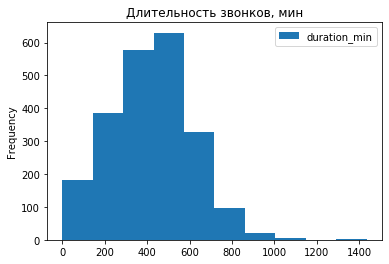

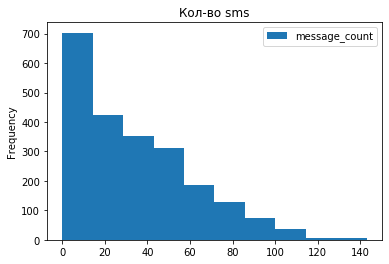

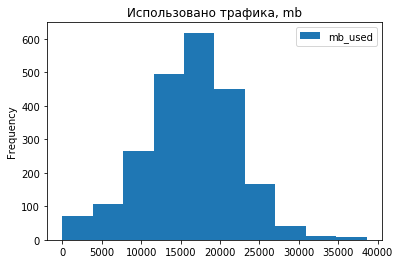

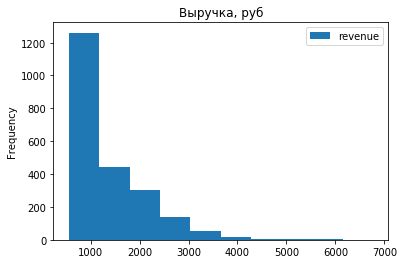

In [27]:
# гистограммы параметров
value_list = [['duration_min', 'Длительность звонков, мин'], 
              ['message_count', 'Кол-во sms'], 
              ['mb_used', 'Использовано трафика, mb'],
              ['revenue', 'Выручка, руб']
             ]        

print('Помесячное использование ресурсов на тарифе Smart:')
draw_hist(resources_total.query('tariff == "smart"'), value_list, 10)

#### Анализ поведения среднего пользователя тарифа Smart
Типовой Пользователь разговаривает 400 - 500 мин в месяц (417 среднее знач.), отправляет 20 - 30 sms (33 среднее знач.), расходует около 17 Gb трафика (16200 mb среднее знач.)  
Средняя выручка 1290 руб/мес, при этом, абон. плата всего 550 руб.

In [28]:
print('Статистика для клиентов на тарифе Ultra:',
      '\n\n',
     resources_total
      .query('tariff == "ultra"')
      .loc[:, ['duration_min','mb_used','message_count', 'revenue']]
      .describe()
     )

Статистика для клиентов на тарифе Ultra: 

        duration_min       mb_used  message_count      revenue
count    985.000000    985.000000     985.000000   985.000000
mean     526.623350  19486.901523      49.363452  2071.065990
std      317.606098  10096.317202      47.804457   378.802377
min        0.000000      0.000000       0.000000  1950.000000
25%      284.000000  11785.000000       6.000000  1950.000000
50%      518.000000  19324.000000      38.000000  1950.000000
75%      752.000000  26863.000000      79.000000  1950.000000
max     1673.000000  49789.000000     224.000000  4800.000000


Помесячное использование ресурсов на тарифе Ultra:


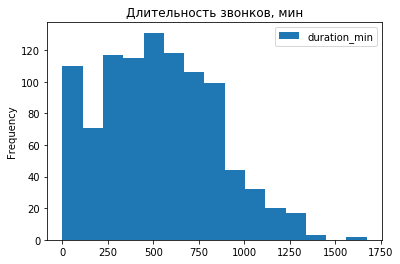

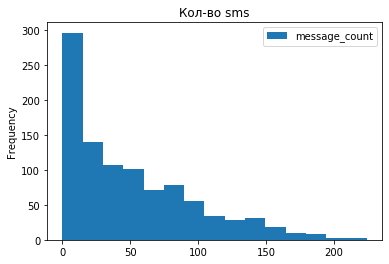

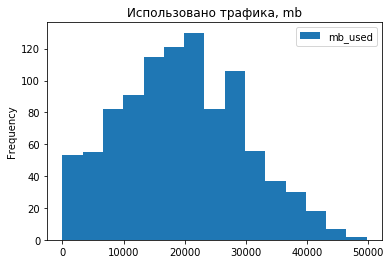

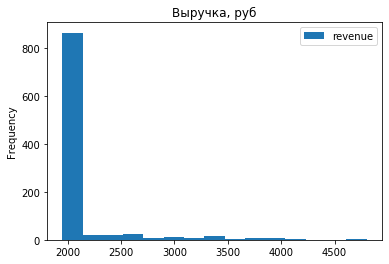

In [29]:
print('Помесячное использование ресурсов на тарифе Ultra:')
draw_hist(resources_total.query('tariff == "ultra"'), value_list, 15)

#### Анализ поведения среднего пользователя тарифа Ultra
Типовой Пользователь разговаривает 250 - 600 мин в месяц (526 среднее знач.), но также много пользователей, которые разговаривают меньше 100 мин/мес. Отправляет меньше 30 sms (49 среднее знач.), расходует около 20 Gb трафика (19400 mb среднее знач.)  
Средняя выручка 2070 руб/мес, при этом, абон. плата по тарифу 1950 руб. Т.е. средняя выручка с клиента всего на 100 руб выше абон. платы.

Text(0.5, 1, 'Средняя помесячная выручка с клиента')

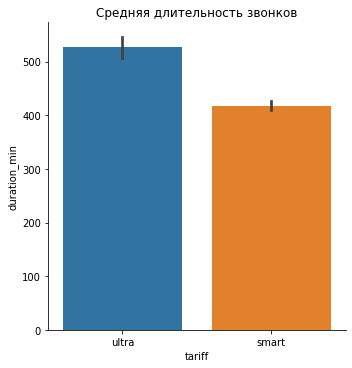

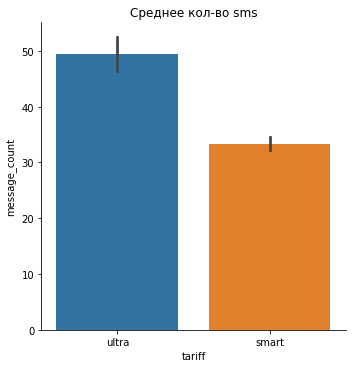

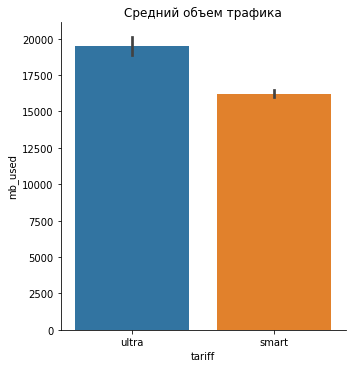

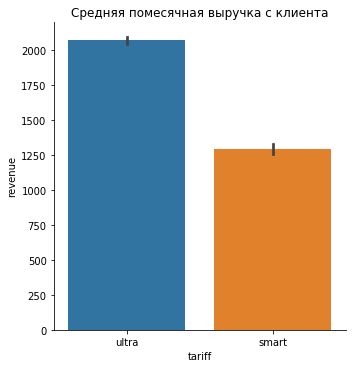

In [30]:
# сравним также средние значения для двух тарифов
sns.catplot(x='tariff', y='duration_min', data=resources_total, kind='bar')
plt.title('Средняя длительность звонков')

sns.catplot(x='tariff', y='message_count', data=resources_total, kind='bar')
plt.title('Среднее кол-во sms')

sns.catplot(x='tariff', y='mb_used', data=resources_total, kind='bar')
plt.title('Средний объем трафика')

sns.catplot(x='tariff', y='revenue', data=resources_total, kind='bar')
plt.title('Средняя помесячная выручка с клиента')

#### Сравнение тарифов
- Для тарифа Ultra средняя длительность звонков, кол-во сообщений и объем трафика за месяц выше чем для тарифа Smart.
- Средняя выручка для двух тарифов выше абонентской платы тарифов, но для Smart средн. выручка превышает абон. плату на 750 руб, а для Ultra всего на 100 руб. Можно сделать вывод, что для клиентов Smart кол-во бесплатных ресурсов в тарифе недостаточно, т.к. клиенты покупают дополнительные ресурсы.
- Средняя выручка по тарифу Ultra выше чем по тарифу Smart.

In [31]:
# средние значения, дисперсию и стандартное отклонение сохраним в отдельный датасет
resources_total_smart = resources_total.query('tariff == "smart"').reset_index(drop=True)

resources_total_ultra = resources_total.query('tariff == "ultra"').reset_index(drop=True)

smart_statistics = pd.DataFrame({'duration_min': [resources_total_smart['duration_min'].describe()['mean'], 
                                                  np.var(resources_total_smart['duration_min'], ddof=1), 
                                                  resources_total_smart['duration_min'].describe()['std']],
                                 'message_count': [resources_total_smart['message_count'].describe()['mean'], 
                                                  np.var(resources_total_smart['message_count'], ddof=1), 
                                                  resources_total_smart['message_count'].describe()['std']],
                                 'mb_used': [resources_total_smart['mb_used'].describe()['mean'], 
                                                  np.var(resources_total_smart['mb_used'], ddof=1), 
                                                  resources_total_smart['mb_used'].describe()['std']]
                                
                                }, 
                                 index=['mean', 'variation', 'std']
                                )

print('Тариф Smart:')

smart_statistics

Тариф Smart:


,duration_min,message_count,mb_used
mean,417.934948,33.384029,1.622919e+04
variation,36219.315784,796.812958,3.454591e+07
std,190.313730,28.227876,5.877577e+03


In [32]:
ultra_statistics = pd.DataFrame({'duration_min': [resources_total_ultra['duration_min'].describe()['mean'], 
                                                  np.var(resources_total_ultra['duration_min'], ddof=1), 
                                                  resources_total_ultra['duration_min'].describe()['std']],
                                 'message_count': [resources_total_ultra['message_count'].describe()['mean'], 
                                                  np.var(resources_total_ultra['message_count'], ddof=1), 
                                                  resources_total_ultra['message_count'].describe()['std']],
                                 'mb_used': [resources_total_ultra['mb_used'].describe()['mean'], 
                                                  np.var(resources_total_ultra['mb_used'], ddof=1), 
                                                  resources_total_ultra['mb_used'].describe()['std']]
                                
                                }, 
                                 index=['mean', 'variation', 'std']
                                )

print('Тариф Ultra:')

ultra_statistics

Тариф Ultra:


,duration_min,message_count,mb_used
mean,526.623350,49.363452,1.948690e+04
variation,100873.633397,2285.266143,1.019356e+08
std,317.606098,47.804457,1.009632e+04


### Вывод
- поведение пользователя тарифа Smart  
Типовой Пользователь разговаривает 400 - 500 мин в месяц (417 среднее знач.), отправляет 20-30 sms (33 среднее знач.), расходует около 17 Gb трафика (16200 mb среднее знач.) Средняя выручка 1290 руб/мес.

- поведение пользователя тарифа Ultra  
Типовой Пользователь разговаривает 250 - 600 мин в месяц (526 среднее знач.), но также много пользователей, которые разговаривают меньше 100 мин/мес. Отправляет меньше 30 sms (49 среднее знач.), расходует около 20 Gb трафика (19400 mb среднее знач.). Средняя выручка 2070 руб/мес

- Сравнение тарифов  
Для тарифа Ultra средняя длительность звонков, кол-во сообщений и объем трафика за месяц выше чем для тарифа Smart. Средняя выручка для двух тарифов выше абонентской платы тарифов, но для Smart средн. выручка превышает абон. плату на 750 руб, а для Ultra всего на 100 руб. Можно сделать вывод, что для клиентов Smart кол-во бесплатных ресурсов в тарифе недостаточно, т.к. клиенты покупают дополнительные ресурсы.  
Средняя выручка по тарифу Ultra выше чем по тарифу Smart.

- Построены диаграммы помесячного распределения использования ресурсов пользователями  
Тип распределения для всех параметров - нормальное распределение
- Посчитаны значения дисперсии и стандартного отклонения для параметров

### Шаг 4. Проверка гипотез
Проверьте гипотезы:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#### Гипотеза 1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

__Нулевая гипотеза__: средняя помесячная выручка пользователей тарифа Ultra равна средней помесячной выручке пользователей тарифа Smart  
__Альтернативная гипотеза__: средняя помесячная выручка пользователей тарифа Ultra не равна средней помесячной выручке пользователей тарифа Smart  
Необходимо проверить гипотезу о равенстве двух независимых генеральных совокупностей. Совокупности являются независимыми, т.к. поведение пользователей одного тарифа никак не связаны и не влияют на поведение пользователей второго тарифа.
  
Уровень статистической значимости возьмем 1%

In [33]:
alpha = .01
results = st.ttest_ind(resources_total_smart
                       .loc[:, 'revenue']
                       .to_list(), 
                       resources_total_ultra
                       .loc[:, 'revenue']
                       .to_list()
                      )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.9776448000521676e-158
Отвергаем нулевую гипотезу


__Нулевая гипотеза отвергается__, т.е. средняя помесячная выручка пользователей тарифа Ultra __не равна__ средней помесячной выручке пользователей тарифа Smart.  
Результаты проверки гипотезы не противоречат выводу, который был сделан на шаге анализа данных: Средняя выручка по тарифу Ultra выше чем по тарифу Smart.

#### Гипотеза 2 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

__Нулевая гипотеза__: средняя помесячная выручка (для двух тарифов) пользователей из Москвы равна средней помесячной выручке пользователей из других городов  
__Альтернативная гипотеза__: средняя помесячная выручка (для двух тарифов) пользователей из Москвы не равна средней помесячной выручке пользователей из других городов  
Необходимо проверить гипотезу о равенстве двух независимых генеральных совокупностей. Совокупности являются независимыми, т.к. поведение пользователей из Москвы никак не связаны и не влияют на поведение пользователей других городов.
  
Уровень статистической значимости возьмем 1%

In [34]:
# Нужно получить среднюю выручку по пользователям и смерджить с таблицей users, чтобы затем выделить пользователей из Москвы
users_revenue_mean = resources_total.groupby(by='user_id').agg({'revenue':['mean']})
users_revenue_mean.set_axis(['revenue_mean'], axis=1, inplace=True)

users_revenue_mean.head()

,revenue_mean
user_id,
1000,1950.000000
1001,950.000000
1002,1035.714286
1003,1950.000000
1004,1950.000000


In [35]:
# добавим ср. выручку в таблицу users
users = users.merge(users_revenue_mean, on='user_id', how='left')

In [36]:
# проверим новый столбец на пустые значения
print(users['revenue_mean'].describe())

# есть два пустых значения, т.е. клиент из выборки платил абон. плату, но не совершал звонков и т.д.
# заполним пропуски значениями из тарифа
users.loc[(users['revenue_mean'].isna()) & (users['tariff'] == 'smart'), 'revenue_mean'] = 550
users.loc[(users['revenue_mean'].isna()) & (users['tariff'] == 'ultra'), 'revenue_mean'] = 1950

print(users[users['revenue_mean'].isna()]['revenue_mean'].count())

count     498.000000
mean     1554.903727
std       636.808558
min       550.000000
25%      1009.553571
50%      1621.333333
75%      1950.000000
max      4333.333333
Name: revenue_mean, dtype: float64
0


In [37]:
# проверим, что названия городов не дублируются
users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [38]:
# сделаем срез по клиентам из Москвы и остальным городам
users_moscow = users.query('city == "Москва"')
users_other = users.query('city != "Москва"')

In [39]:
# проверка гипотезы
alpha = .01
results = st.ttest_ind(users_moscow
                       .loc[:, 'revenue_mean']
                       .to_list(), 
                       users_other
                       .loc[:, 'revenue_mean']
                       .to_list()
                      )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.38656613797487016
Не получилось отвергнуть нулевую гипотезу


__Нулевая гипотеза верна__, т.е. средняя помесячная выручка (для двух тарифов) пользователей из Москвы __равна__ средней помесячной выручке пользователей из других городов

## Общий вывод
### Шаг 1 Изучение общей информации о данных
Было проведено изучение общей информации: доступны данные об 500 клиентах, 202 607 звонках, 123 036 сообщениях, 149 396 интернет сессиях. Пропуски в данных отсутствуют, в таблице Internet есть некорректный столбец.

### Шаг 2 Предобработка данных
- поля содержащие календарную дату приведены к типу datetime64
- Таблица calls.   
Добавлен столбец с длительностью звонков с округлением по правилам тарификации.
Почти 20% от общего объема звонков - это пропущенные вызовы (нулевая длительность). Тем не менее, это звонки, которые клиенты пытались совершить. При дальнейшем анализе их нужно учесть в расчетах.
- Столбец Internet  
Лишний "неименованный" столбец удален, удалены сессии с нулевым объемом трафика, добавлен столбец с объемом трафика с округлением по правилам тарификации.

### Шаг 2 Расчет использованных пользователями ресурсов
Создан отдельный датасет содержащий помесячные расчеты по клиентам:
- количество сделанных звонков и израсходованных минут разговора
- количество отправленных сообщений
- объем израсходованного интернет-трафика
- помесячную выручку с каждого пользователя

### Шаг 3 Анализ поведения пользователей
- поведение пользователей тарифа Smart  
Типовой Пользователь разговаривает 400 - 500 мин в месяц (417 среднее), отправляет 20-30 sms (33 среднее), расходует около 17 Gb трафика (16200 mb среднее) Средняя выручка 1290 руб/мес.

- поведение пользователя тарифа Ultra  
Типовой Пользователь разговаривает 250 - 600 мин в месяц (526 среднее), но также много пользователей, которые разговаривают меньше 100 мин/мес. Отправляет меньше 30 sms (49 среднее), расходует около 20 Gb трафика (19400 mb среднее). Средняя выручка 2070 руб/мес.

- Сравнение тарифов  
Для тарифа Ultra средняя длительность звонков, кол-во сообщений и объем трафика за месяц выше чем для тарифа Smart. Средняя выручка для двух тарифов выше абонентской платы тарифов, но для Smart средн. выручка превышает абон. плату на 750 руб, а для Ultra всего на 100 руб. Можно сделать вывод, что для клиентов Smart кол-во бесплатных ресурсов в тарифе недостаточно, т.к. клиенты покупают дополнительные ресурсы.  
Средняя выручка по тарифу Ultra выше чем по тарифу Smart.

- Построены диаграммы помесячного распределения использования ресурсов пользователями  
- Посчитаны значения дисперсии и стандартного отклонения для параметров

### Шаг 4 Проверка гипотез
Были проверены две гипотезы о равенстве средних двух генеральных совокупностей. 
- Гипотеза 1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается  
__Нулевая гипотеза__: средняя помесячная выручка пользователей тарифа Ultra равна средней помесячной выручке пользователей тарифа Smart  
__Альтернативная гипотеза__: средняя помесячная выручка пользователей тарифа Ultra не равна средней помесячной выручке пользователей тарифа Smart  
Уровень статистической значимости 1%

Результат: __Нулевая гипотеза отвергается__, т.е. средняя помесячная выручка пользователей тарифа Ultra __не равна__ средней помесячной выручке пользователей тарифа Smart.  
Результаты проверки гипотезы не противоречат выводу, который был сделан на шаге анализа данных: Средняя выручка по тарифу Ultra выше чем по тарифу Smart.

- Гипотеза 2 - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов  
__Нулевая гипотеза__: средняя помесячная выручка (для двух тарифов) пользователей из Москвы равна средней помесячной выручке пользователей из других городов  
__Альтернативная гипотеза__: средняя помесячная выручка (для двух тарифов) пользователей из Москвы не равна средней помесячной выручке пользователей из других городов  
Необходимо проверить гипотезу о равенстве двух независимых генеральных совокупностей. Совокупности являются независимыми, т.к. поведение пользователей из Москвы никак не связаны и не влияют на поведение пользователей других городов.
Уровень статистической значимости 1%

Результат: __Нулевая гипотеза верна__, т.е. средняя помесячная выручка (для двух тарифов) пользователей из Москвы __равна__ средней помесячной выручке пользователей из других городов

__Для Оператора с точки зрения ежемесячной средней выручки с одного клиента выгодней тариф Ultra__